In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import numpy as np
from pathlib import Path
import modules.guided_diffusion as gd
from modules.dataset import SpectrumDataset
from modules.model import UNETv1
from modules.plotting_utils import *

In [2]:
def create_gaussian_diffusion(
        *,
        steps=1000,
        learn_sigma=False,
        sigma_small=False,
        noise_schedule="linear",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        timestep_respacing="",
):
    betas = gd.get_named_beta_schedule(noise_schedule, steps)
    if use_kl:
        loss_type = gd.LossType.RESCALED_KL
    elif rescale_learned_sigmas:
        loss_type = gd.LossType.RESCALED_MSE
    else:
        loss_type = gd.LossType.MSE
    if not timestep_respacing:
        timestep_respacing = [steps]
    return gd.SpacedDiffusion(
        use_timesteps=gd.space_timesteps(steps, timestep_respacing),
        betas=betas,
        model_mean_type=(
            gd.ModelMeanType.EPSILON if not predict_xstart else gd.ModelMeanType.START_X
        ),
        model_var_type=(
            (
                gd.ModelVarType.FIXED_LARGE
                if not sigma_small
                else gd.ModelVarType.FIXED_SMALL
            )
            if not learn_sigma
            else gd.ModelVarType.LEARNED_RANGE
        ),
        loss_type=loss_type,
        rescale_timesteps=rescale_timesteps,
    )


diffusion = create_gaussian_diffusion()

In [3]:
data_folder = Path(r'C:\Users\smerino.C084288\Documents\Datasets\ACS')
data = SpectrumDataset(data_folder/'train')
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

sample_id = 0
x_sample,y_sample = data.__getitem__(sample_id)
x_sample = x_sample.unsqueeze(0)
y_sample = y_sample.unsqueeze(0)

# Trained model: UNET v1

Num params:  32786625


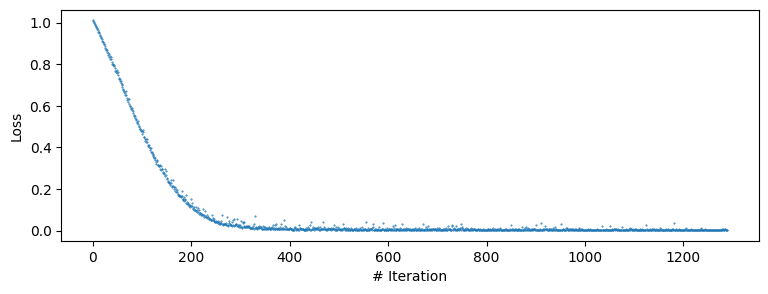

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = Path(r'.\weights\v1')
training_epochs = 30
model1 = UNETv1(in_channels=80, residual=False, attention_res=[]).to(device)
model1.load_state_dict(torch.load(save_dir / f"model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model1.parameters()))

plt.figure(figsize=(9, 3))
loss_npy = np.load(save_dir / f"loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
# plt.ylim(0, 0.01)
plt.show()

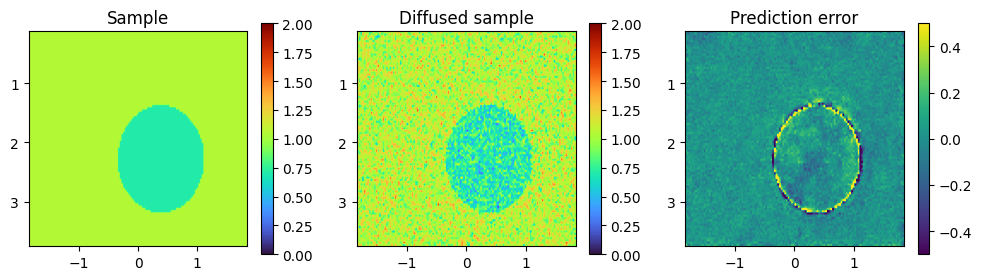

In [15]:
timestep = 50
noise = torch.randn_like(y_sample)
t = torch.reshape(torch.Tensor([timestep]).int(), (x_sample.shape[0],)).to(device)
y_pert = diffusion.q_sample(y_sample, t, noise)

# use network to recover noise
predicted_noise = model1(x_sample, y_pert, t)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
show_tensor_image(y_sample.cpu().detach())
plt.set_cmap('turbo')
plt.colorbar()
plt.title('Sample')

plt.subplot(1, 3, 2)
show_tensor_image(y_pert.cpu().detach())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Diffused sample')

pred_error = (noise - predicted_noise).cpu().detach().squeeze()
plt.subplot(1, 3, 3)
plt.imshow(pred_error, extent=(-1.845, 1.845, 3.751, 0.128))
plt.colorbar()
plt.clim(-0.5, 0.5)
plt.set_cmap('viridis')
plt.title('Prediction error')
plt.show()

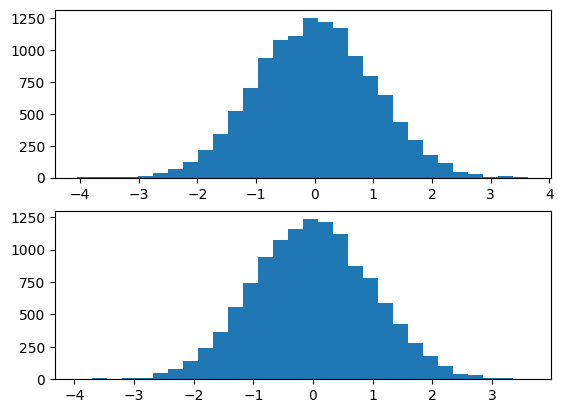

In [6]:
noise_vec = noise.detach().cpu().numpy().flatten()
pred_noise_vec = predicted_noise.detach().cpu().numpy().flatten()
plt.subplot(2, 1, 1)
plt.hist(noise_vec, bins=30)
plt.subplot(2, 1, 2)
plt.hist(pred_noise_vec, bins=30)
plt.show()

In [7]:
from torchinfo import summary

summary(model1, input_data=[x_sample, y_sample, t], depth=4)

Layer (type:depth-idx)                   Output Shape              Param #
UNETv1                                   [1, 1, 96, 128]           --
├─Sequential: 1-1                        [1, 256]                  --
│    └─PositionalEncoding: 2-1           [1, 64]                   --
│    └─Linear: 2-2                       [1, 256]                  16,640
│    └─SiLU: 2-3                         [1, 256]                  --
│    └─Linear: 2-4                       [1, 256]                  65,792
├─Conv2d: 1-2                            [1, 64, 96, 128]          5,184
├─ResBlock: 1-3                          [1, 64, 96, 128]          --
│    └─Sequential: 2-5                   [1, 64, 96, 128]          --
│    │    └─GroupNorm32: 3-1             [1, 64, 96, 128]          128
│    │    └─SiLU: 3-2                    [1, 64, 96, 128]          --
│    │    └─Conv2d: 3-3                  [1, 64, 96, 128]          36,928
│    └─Sequential: 2-6                   [1, 128]                  --

# New model

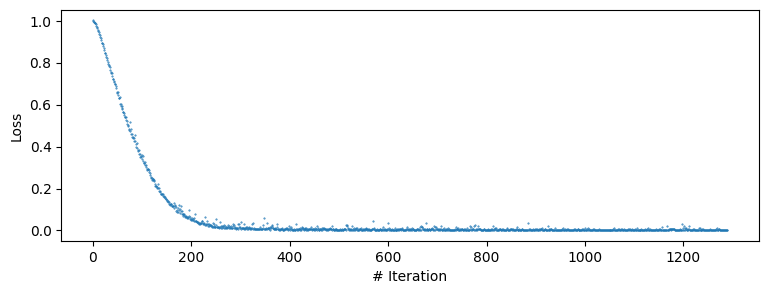

In [8]:
from modules.model import UNETv2

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = Path(r'.\weights\v2')
training_epochs = 30
model2 = UNETv2(in_channels=80, residual=False, attention_res=[]).to(device)
model2.load_state_dict(torch.load(save_dir / f"model_{training_epochs}.pth", map_location=device))

plt.figure(figsize=(9, 3))
loss_npy = np.load(save_dir / f"loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
# plt.ylim(0, 0.01)
plt.show()


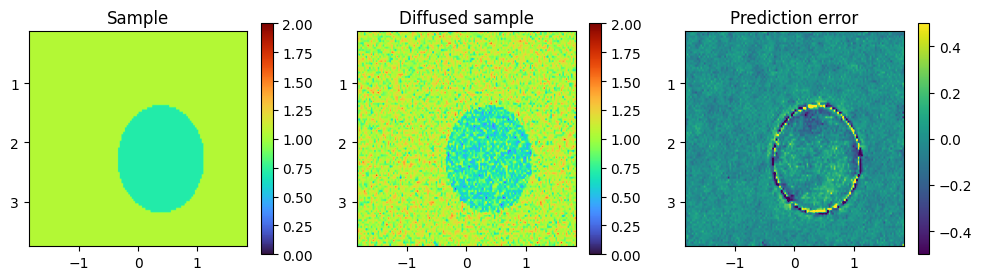

In [16]:
timestep = 50
noise = torch.randn_like(y_sample)
t = torch.reshape(torch.Tensor([timestep]).int(), (x_sample.shape[0],)).to(device)
y_pert = diffusion.q_sample(y_sample, t, noise)

# use network to recover noise
predicted_noise = model2(x_sample, y_pert, t)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
show_tensor_image(y_sample.cpu().detach())
plt.set_cmap('turbo')
plt.colorbar()
plt.title('Sample')

plt.subplot(1, 3, 2)
show_tensor_image(y_pert.cpu().detach())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Diffused sample')

pred_error = (noise - predicted_noise).cpu().detach().squeeze()
plt.subplot(1, 3, 3)
plt.imshow(pred_error, extent=(-1.845, 1.845, 3.751, 0.128))
plt.colorbar()
plt.clim(-0.5, 0.5)
plt.set_cmap('viridis')
plt.title('Prediction error')
plt.show()

# Model 2B: residual

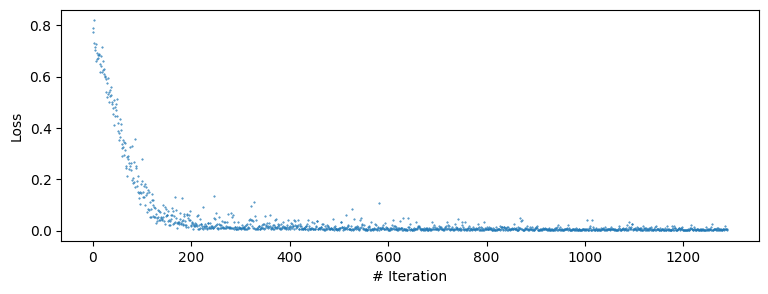

In [17]:
from modules.model import UNETv2

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = Path(r'.\weights\v2B')
training_epochs = 30
model2 = UNETv2(in_channels=80, residual=True, attention_res=[]).to(device)
model2.load_state_dict(torch.load(save_dir / f"model_{training_epochs}.pth", map_location=device))

plt.figure(figsize=(9, 3))
loss_npy = np.load(save_dir / f"loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
#plt.xlim(000,35000)
# plt.ylim(0, 0.01)
plt.show()

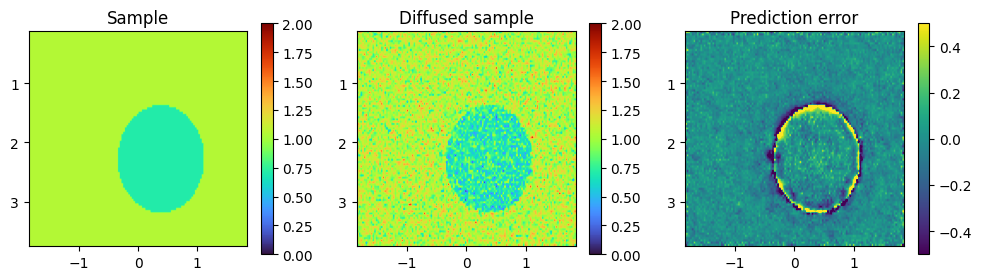

In [18]:
timestep = 50
noise = torch.randn_like(y_sample)
t = torch.reshape(torch.Tensor([timestep]).int(), (x_sample.shape[0],)).to(device)
y_pert = diffusion.q_sample(y_sample, t, noise)

# use network to recover noise
predicted_noise = model2(x_sample, y_pert, t)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
show_tensor_image(y_sample.cpu().detach())
plt.set_cmap('turbo')
plt.colorbar()
plt.title('Sample')

plt.subplot(1, 3, 2)
show_tensor_image(y_pert.cpu().detach())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Diffused sample')

pred_error = (noise - predicted_noise).cpu().detach().squeeze()
plt.subplot(1, 3, 3)
plt.imshow(pred_error, extent=(-1.845, 1.845, 3.751, 0.128))
plt.colorbar()
plt.clim(-0.5, 0.5)
plt.set_cmap('viridis')
plt.title('Prediction error')
plt.show()